<a href="https://colab.research.google.com/github/JhaAkansha/SnowCapMeltAnalysis/blob/main/RS_OEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install earthengine-api geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.9 MB/s eta 0:00:00


In [ ]:
pip install folium

In [2]:
import ee
ee.Authenticate()
ee.Initialize(project='snowcapmelt')

In [84]:
import datetime
import matplotlib.pyplot as plt
import geemap
import numpy as np
import pandas as pd
from tqdm import tqdm
import folium
import seaborn as sns

In [4]:
#Mean VV backscatter (dB)	Higher = dry snow or ice, Lower = wet/melted
regions = {
    'Greenland': ee.Geometry.Polygon([[[-52, 60], [-52, 80], [-30, 80], [-30, 60], [-52, 60]]]),
    'Svalbard': ee.Geometry.Polygon([[[10, 76], [10, 82], [35, 82], [35, 76], [10, 76]]]),
    'Canadian Arctic': ee.Geometry.Polygon([[[-100, 65], [-100, 75], [-70, 75], [-70, 65], [-100, 65]]]),
    'Antarctic Peninsula': ee.Geometry.Polygon([[[-75, -75], [-75, -60], [-50, -60], [-50, -75], [-75, -75]]]),
    'Patagonia': ee.Geometry.Polygon([[[-75, -55], [-75, -45], [-70, -45], [-70, -55], [-75, -55]]]),
}

years = list(range(2015, 2024))

def get_s1_vv(region, year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = ee.Date.fromYMD(year, 12, 31)

    s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterDate(start, end) \
        .filterBounds(region) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .select('VV')

    if s1.size().getInfo() == 0:
        return None

    median = s1.median().clip(region)
    stats = median.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=5000,
        maxPixels=1e13,
        tileScale=8
    )
    return stats.get('VV').getInfo()

results = {name: [] for name in regions.keys()}

for year in years:
    print(f"\nProcessing {year}...")
    for name, geom in regions.items():
        try:
            print(f"  {name}...", end='')
            vv = get_s1_vv(geom, year)
            results[name].append(vv)
            print("OK")
        except Exception as e:
            print(f"error ({e})")
            results[name].append(None)


Processing 2015...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2016...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2017...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2018...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2019...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2020...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2021...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2022...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2023...
  Greenland...OK
  S

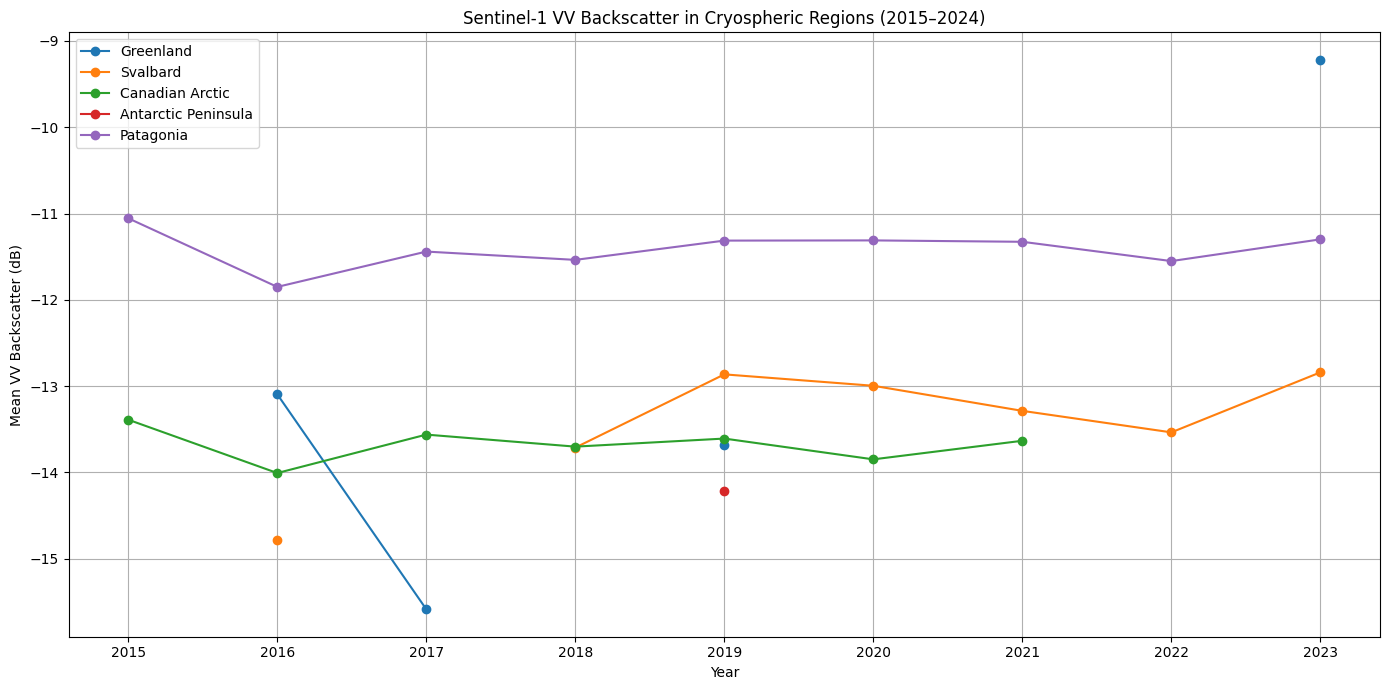

In [5]:
#Higher VV: Dry snow or ice (–10 dB to –5 dB).
#Lower VV: Wet snow or melting zones (–20 dB and lower)

plt.figure(figsize=(14, 7))
for name, values in results.items():
    plt.plot(years, values, marker='o', label=name)

plt.title('Sentinel-1 VV Backscatter in Cryospheric Regions (2015–2024)')
plt.xlabel('Year')
plt.ylabel('Mean VV Backscatter (dB)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
dataset = ee.ImageCollection('MODIS/061/MOD10A1').filter(ee.Filter.date('2000-04-01', '2000-05-01'));
snowCover_2000 = dataset.select('NDSI_Snow_Cover');
snowCoverVis = {
  'min': 0.0,
  'max': 100.0,
  'palette': ['black', '0dffff', '0524ff', 'ffffff'],
};
Map2000 = geemap.Map(center=[-41.13, 76.35], zoom=3)
Map2000.setCenter(-41.13, 76.35, 3);
Map2000.addLayer(snowCover_2000, snowCoverVis, 'Snow Cover');
Map2000

Map(center=[76.35, -41.13], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

In [7]:
dataset = ee.ImageCollection('MODIS/061/MOD10A1').filter(ee.Filter.date('2024-04-01', '2024-05-01'));
snowCover_2024 = dataset.select('NDSI_Snow_Cover');
snowCoverVis = {
  'min': 0.0,
  'max': 100.0,
  'palette': ['black', '0dffff', '0524ff', 'ffffff'],
};
Map2024 = geemap.Map(center=[-41.13, 76.35], zoom=3)
Map2024.setCenter(-41.13, 76.35, 3);
Map2024.addLayer(snowCover_2024, snowCoverVis, 'Snow Cover');
Map2024

Map(center=[76.35, -41.13], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

In [8]:
snowCover_2000 = snowCover_2000.mean()
snowCover_2024 = snowCover_2024.mean()
difference = snowCover_2024.subtract(snowCover_2000)
differenceVis = {
    'min': -100.0,
    'max': 100.0,
    'palette': ['blue', 'white', 'red'],
}
MapDiff = geemap.Map(center=[76.35, -41.13], zoom=3)
MapDiff.addLayer(difference, differenceVis, 'Snow Cover Difference (2024 - 2000)')
MapDiff
# red shows a decrease in the snow cover while blue shows an increase

Map(center=[76.35, -41.13], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

In [9]:
#Landsat does not cover most of the Antarctic interior due to orbital constraints.
#most imagery is cloud-covered or unavailable during Antarctic winter.

In [10]:
#Sentinel 1 is not optical and therefore does not give NDSI hence we use backscatter

In [72]:
#Getting data for 2000 to 2014 from MODIS since Sentinel-1 does not have data before 2015
#MODIS gives fraction of area snow-covered: 0 (none) to 1 (fully covered). Sentinel-1 VV gives backscatter (dB): useful for wet snow / ice transitions (inversely proportional to ndsi)

In [12]:
regions = {
    'Greenland': ee.Geometry.Polygon([[[-52, 60], [-52, 80], [-30, 80], [-30, 60], [-52, 60]]]),
    'Svalbard': ee.Geometry.Polygon([[[10, 76], [10, 82], [35, 82], [35, 76], [10, 76]]]),
    'Canadian Arctic': ee.Geometry.Polygon([[[-100, 65], [-100, 75], [-70, 75], [-70, 65], [-100, 65]]]),
    'Antarctic Peninsula': ee.Geometry.Polygon([[[-75, -75], [-75, -60], [-50, -60], [-50, -75], [-75, -75]]]),
    'Patagonia': ee.Geometry.Polygon([[[-75, -55], [-75, -45], [-70, -45], [-70, -55], [-75, -55]]]),
}
years = list(range(2000, 2025))

In [13]:
def get_snow_metric(region_geom, year, region_name):
    try:
        # Set season per hemisphere
        if region_name.lower().startswith('antarctic') or region_name == 'Patagonia':
            start = f'{year}-12-01'
            end = f'{year+1}-02-28'
        else:
            start = f'{year}-06-15'
            end = f'{year}-08-15'

        # MODIS if year < 2015
        if year < 2015:
            modis = ee.ImageCollection('MODIS/006/MOD10A1') \
            .filterDate(start, end) \
            .filterBounds(region_geom) \
            .select(['NDSI_Snow_Cover', 'NDSI_Snow_Cover_Basic_QA'])

            # Cloud mask function
            def mask_modis_clouds(img):
              qa = img.select('NDSI_Snow_Cover_Basic_QA')
              snow = img.select('NDSI_Snow_Cover')
              mask = qa.eq(0)                              # Keep pixels where QC = 0 (best quality)
              snow_bin = snow.gt(0).rename('snow')         # Create a binary snow presence band
              return snow_bin.updateMask(mask)
            snow_masked = modis.map(mask_modis_clouds).median()
            stats = snow_masked.reduceRegion(
              reducer=ee.Reducer.mean(),
              geometry=region_geom,
              scale=5000,
              maxPixels=1e13,
              tileScale=4
            )
            return stats.get('snow').getInfo()

        def speckle_filter(image):
          kernel = ee.Kernel.square(radius=1)
          return image.convolve(kernel).copyProperties(image, image.propertyNames())

        # Sentinel-1 VV fallback (SAR)
        s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterDate(start, end) \
        .filterBounds(region_geom) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .select('VV') \
        .map(speckle_filter)

        if s1.size().getInfo() == 0:
            return None

        median = s1.median().clip(region_geom)
        stats = median.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region_geom,
            scale=5000,
            maxPixels=1e13,
            tileScale=4
        )
        value = stats.get('VV')
        return value.getInfo() if value else None

    except Exception as e:
        print(f"  Error {region_name} {year} failed: {e}")
        return None

In [14]:
results = {}
for region_name, region_geom in regions.items():
    print(f"\nProcessing: {region_name}")
    region_results = []
    for year in years:
        print(f"  Year {year}...", end="")
        val = get_snow_metric(region_geom, year, region_name)
        region_results.append(val)
        print("OK" if val is not None else "—")
    results[region_name] = region_results


Processing: Greenland
  Year 2000...OK
  Year 2001...OK
  Year 2002...OK
  Year 2003...OK
  Year 2004...OK
  Year 2005...OK
  Year 2006...OK
  Year 2007...OK
  Year 2008...OK
  Year 2009...OK
  Year 2010...OK
  Year 2011...OK
  Year 2012...OK
  Year 2013...OK
  Year 2014...OK
  Year 2015...—
  Year 2016...—
  Year 2017...—
  Year 2018...—
  Year 2019...—
  Year 2020...—
  Year 2021...—
  Year 2022...—
  Year 2023...—
  Year 2024...—

Processing: Svalbard
  Year 2000...OK
  Year 2001...OK
  Year 2002...OK
  Year 2003...OK
  Year 2004...OK
  Year 2005...OK
  Year 2006...OK
  Year 2007...OK
  Year 2008...OK
  Year 2009...OK
  Year 2010...OK
  Year 2011...OK
  Year 2012...OK
  Year 2013...OK
  Year 2014...OK
  Year 2015...—
  Year 2016...—
  Year 2017...—
  Year 2018...OK
  Year 2019...OK
  Year 2020...OK
  Year 2021...OK
  Year 2022...OK
  Year 2023...OK
  Year 2024...OK

Processing: Canadian Arctic
  Year 2000...OK
  Year 2001...OK
  Year 2002...OK
  Year 2003...OK
  Year 2004...OK
  Ye

Greenland :  [0.969885937318622, 0.9642462243638058, 0.9674052545580966, 0.9643640960830694, 0.9676472772729191, 0.9714517048165315, 0.9688829852204854, 0.9656544783890215, 0.9629704707925018, 0.9661812128856372, 0.9628332816775187, 0.9659770290302567, 0.9639457102892518, 0.9668893188119937, 0.9632746867507062, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Svalbard :  [0.9714623571147024, 0.874920936116382, 0.8728087414511437, 0.8882765136603417, 0.8753435414212799, 0.9089799133517132, 0.9145248762084414, 0.9284148727984345, 0.9583887888514836, 0.9584612961650524, 0.9285434612372748, 0.9318663214874088, 0.9641901463875334, 0.884672735834249, 0.9018067556952082, nan, nan, nan, -16.52696570681359, -16.125652112126442, -15.420656650169882, -15.45742072743886, -15.290497195374355, -16.93079634320252, -16.292305991027106]
Canadian Arctic :  [0.15371340869431113, 0.11668943508128846, 0.18573037596700376, 0.19786239286741775, 0.38728708773700665, 0.20580859382603067, 0.16147569806848192, 

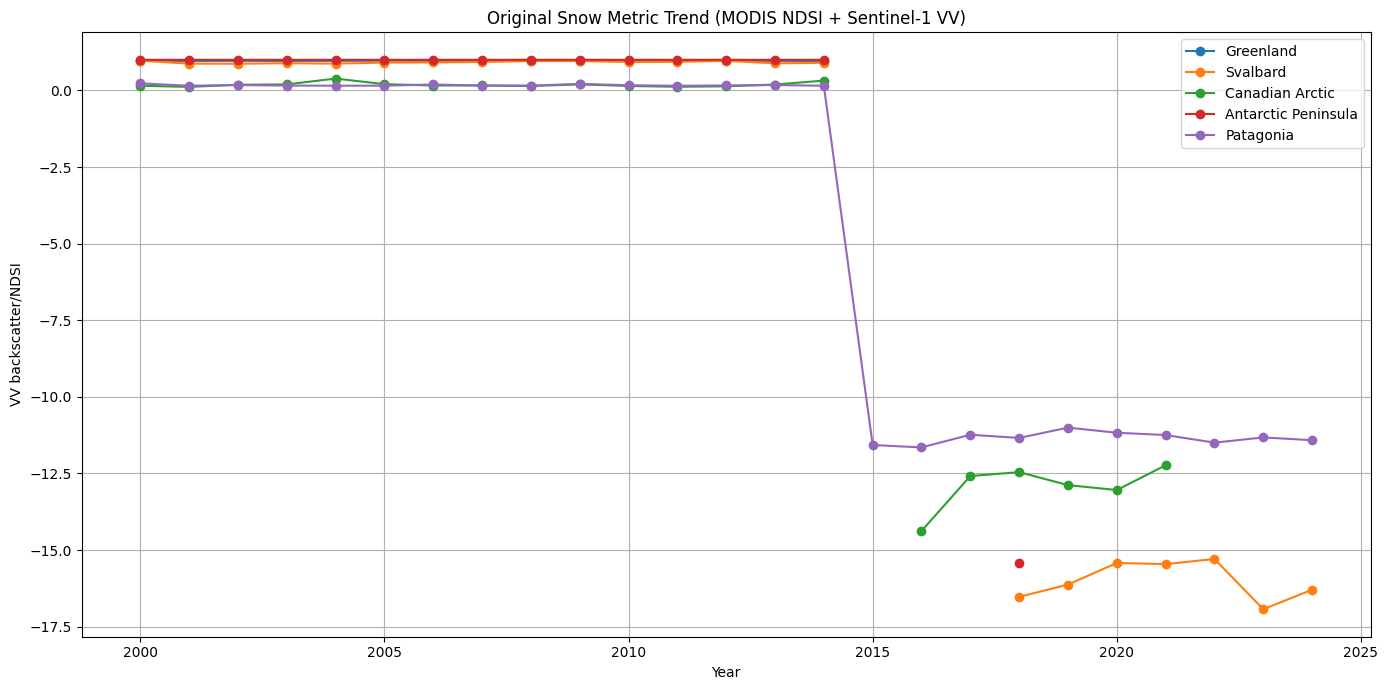

In [15]:
plt.figure(figsize=(14, 7))
for region_name, values in results.items():
    if any(v is not None and not np.isnan(v) for v in values):
        cleaned = [v if v is not None else np.nan for v in values]
        print(region_name, ": ", cleaned)
        plt.plot(years, cleaned, label=region_name, marker='o')
plt.title("Original Snow Metric Trend (MODIS NDSI + Sentinel-1 VV)")
plt.xlabel("Year")
plt.ylabel("VV backscatter/NDSI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

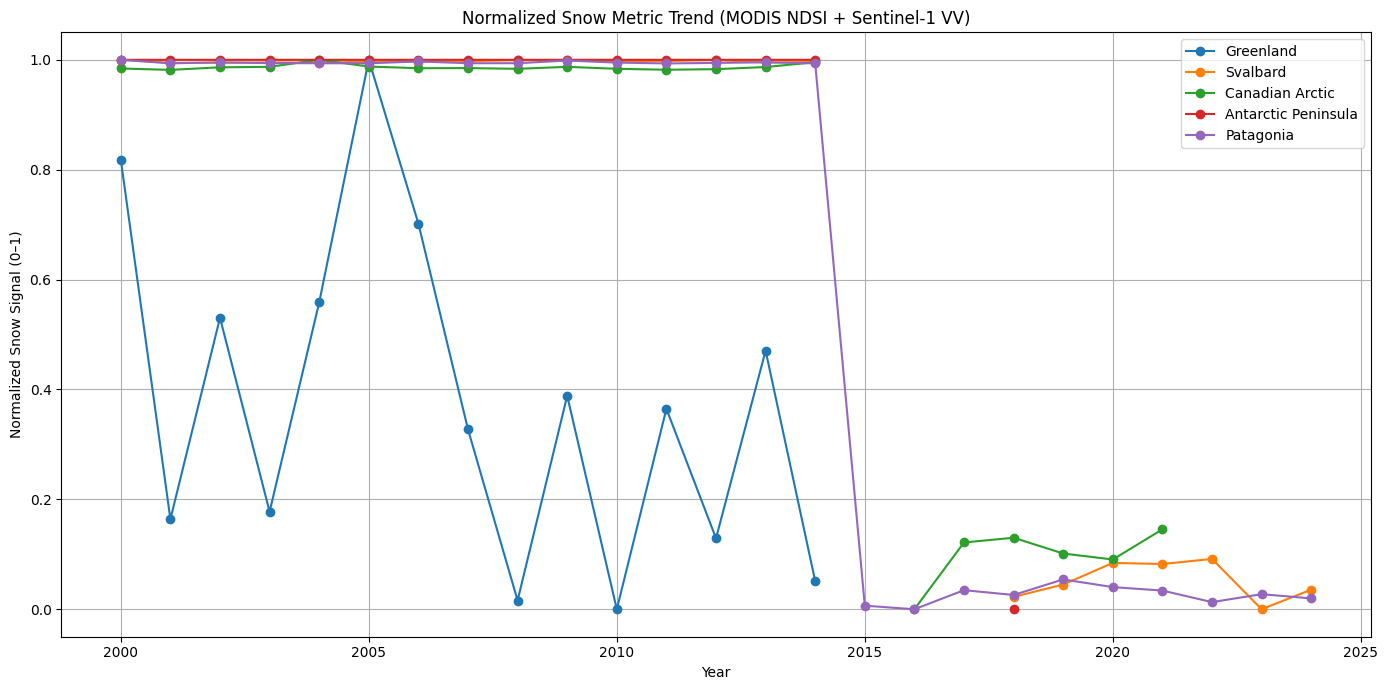

In [16]:
# Normalize data between 0 and 1 for each region
def normalize(series):
    arr = np.array([v if v is not None else np.nan for v in series])
    min_val = np.nanmin(arr)
    max_val = np.nanmax(arr)
    return [(v - min_val) / (max_val - min_val) if v is not None else np.nan for v in arr]

plt.figure(figsize=(14, 7))
for region_name, values in results.items():
    if any(v is not None for v in values):
        norm_vals = normalize(values)
        plt.plot(years, norm_vals, label=region_name, marker='o')

plt.title("Normalized Snow Metric Trend (MODIS NDSI + Sentinel-1 VV)")
plt.xlabel("Year")
plt.ylabel("Normalized Snow Signal (0–1)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
def get_snow(region_geom, year, region_name):
    try:
        # Set season per hemisphere
        if region_name.lower().startswith('antarctic') or region_name == 'Patagonia':
            start = f'{year}-12-01'
            end = f'{year+1}-02-28'
        else:
            start = f'{year}-06-15'
            end = f'{year}-08-15'

        # MODIS if year < 2015
        if year < 2015:
            modis = ee.ImageCollection('MODIS/006/MOD10A1') \
            .filterDate(start, end) \
            .filterBounds(region_geom) \
            .select(['NDSI_Snow_Cover', 'NDSI_Snow_Cover_Basic_QA'])
            if modis.size().getInfo() == 0:
                print(f"No MODIS data for {region_name} in {year}.")
                return None

            # Cloud mask function
            def mask_modis_clouds(img):
                qa = img.select('NDSI_Snow_Cover_Basic_QA')
                snow = img.select('NDSI_Snow_Cover')
                mask = qa.eq(0)                       # Keep pixels where QC = 0 (best quality)
                snow_bin = snow.gt(0).rename('snow')  # Create a binary snow presence band
                return snow_bin.updateMask(mask)

            snow_masked = modis.map(mask_modis_clouds).median()
            return snow_masked.clip(region_geom)

        def speckle_filter(image):
            kernel = ee.Kernel.square(radius=1)
            return image.convolve(kernel).copyProperties(image, image.propertyNames())

        # Sentinel-1 VV fallback (SAR)
        s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
            .filterDate(start, end) \
            .filterBounds(region_geom) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
            .filter(ee.Filter.eq('instrumentMode', 'IW')) \
            .select('VV') \
            .map(speckle_filter)

        if s1.size().getInfo() == 0:
            print(f"No Sentinel-1 data for {region_name} in {year}.")
            return None

        median = s1.median().clip(region_geom)
        return median

    except Exception as e:
        print(f"  Error {region_name} {year} failed: {e}")
        return None

In [18]:
def visualize_on_map(image, region_geom, region_name, year):
    try:
        map_id_dict = image.getMapId({
            'min': 0, 'max': 1, 'palette': ['white', 'blue', 'green']
        })
        map_ = folium.Map(location=[region_geom.centroid().getInfo()['coordinates'][1],
                                    region_geom.centroid().getInfo()['coordinates'][0]], zoom_start=5)
        folium.TileLayer(
            tiles=map_id_dict['tile_fetcher'].url_format,
            attr='Google Earth Engine',
            overlay=True,
            name=f'{region_name} {year}'
        ).add_to(map_)

        return map_
    except Exception as e:
        print(f"Error visualizing map: {e}")
        return None

# visualize for a specific region and year
region_name = 'Greenland'
region_geom = regions['Greenland']
year = 2005

snow_image = get_snow(region_geom, year, region_name)

# If a valid image is returned, visualize it
if snow_image:
    map_output = visualize_on_map(snow_image, region_geom, region_name, year)
    if map_output:
        map_output
else:
    print(f"No valid image for {region_name} in {year}.")
map_output

In [19]:
regions = {
    'Greenland': ee.Geometry.Polygon([[[-52, 60], [-52, 80], [-30, 80], [-30, 60], [-52, 60]]]),
    'Svalbard': ee.Geometry.Polygon([[[10, 76], [10, 82], [35, 82], [35, 76], [10, 76]]]),
    'Canadian Arctic': ee.Geometry.Polygon([[[-100, 65], [-100, 75], [-70, 75], [-70, 65], [-100, 65]]]),
    'Antarctic Peninsula': ee.Geometry.Polygon([[[-75, -75], [-75, -60], [-50, -60], [-50, -75], [-75, -75]]]),
    'Patagonia': ee.Geometry.Polygon([[[-75, -55], [-75, -45], [-70, -45], [-70, -55], [-75, -55]]]),
}
years = list(range(2000, 2025))

data = []

for year in tqdm(years, desc="Processing years"):
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'

    # Load dataset for the year
    gldas = ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H') \
        .filterDate(start_date, end_date) \
        .select(['SnowDepth_inst', 'SWE_inst']) \
        .mean()

    for region_name, geom in regions.items():
        try:
            stats = gldas.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geom,
                scale=25000,
                maxPixels=1e13
            ).getInfo()

            data.append({
                'Year': year,
                'Region': region_name,
                'SnowDepth_m': stats.get('SnowDepth_inst'),
                'SWE_kg_per_m2': stats.get('SWE_inst')
            })

        except Exception as e:
            print(f"Failed for {region_name} in {year}: {e}")
            data.append({
                'Year': year,
                'Region': region_name,
                'SnowDepth_m': None,
                'SWE_kg_per_m2': None
            })
df = pd.DataFrame(data)

Processing years: 100%|██████████| 25/25 [32:14<00:00, 77.39s/it]


In [20]:
print(df)

     Year               Region  SnowDepth_m  SWE_kg_per_m2
0    2000            Greenland    68.961802   27506.077148
1    2000             Svalbard     5.011192    1952.154577
2    2000      Canadian Arctic     0.437547     106.025994
3    2000  Antarctic Peninsula          NaN            NaN
4    2000            Patagonia     0.322587     117.033365
..    ...                  ...          ...            ...
120  2024            Greenland   120.165501   31762.102815
121  2024             Svalbard    10.231121    2685.432920
122  2024      Canadian Arctic     0.456857      81.753573
123  2024  Antarctic Peninsula          NaN            NaN
124  2024            Patagonia     0.786732     214.503735

[125 rows x 4 columns]


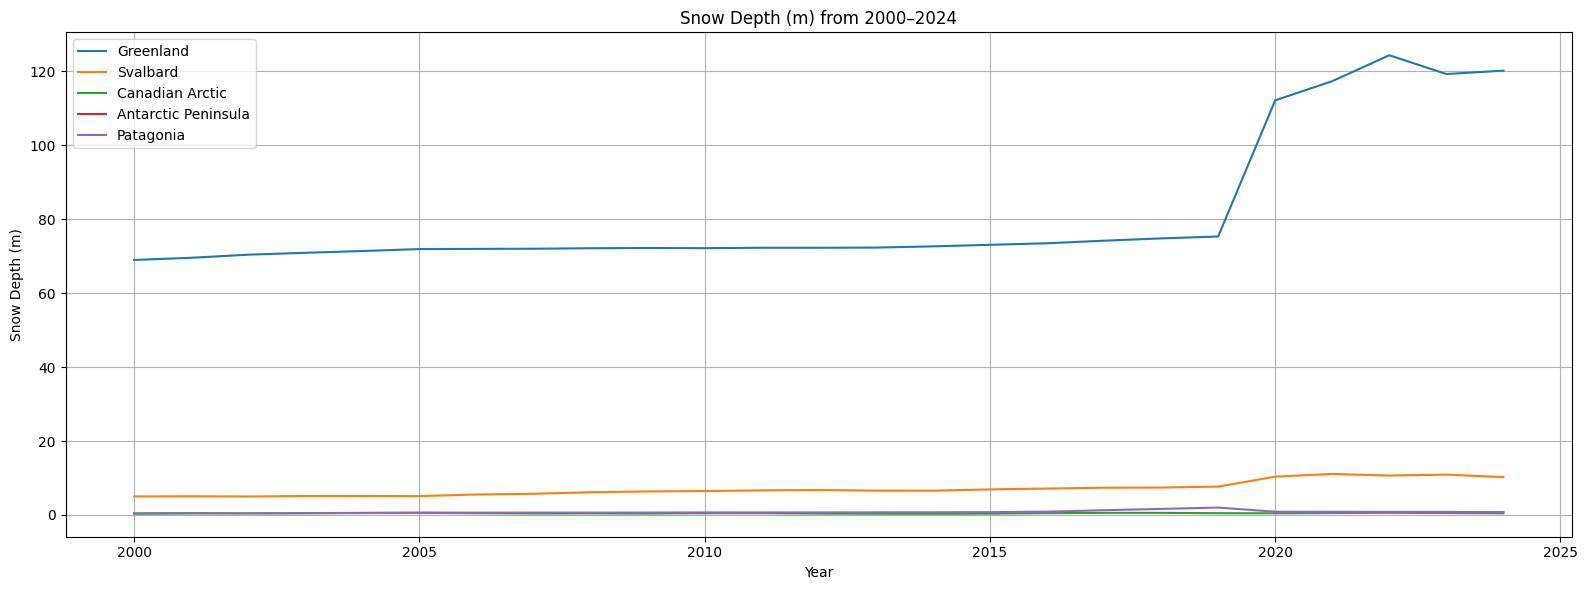

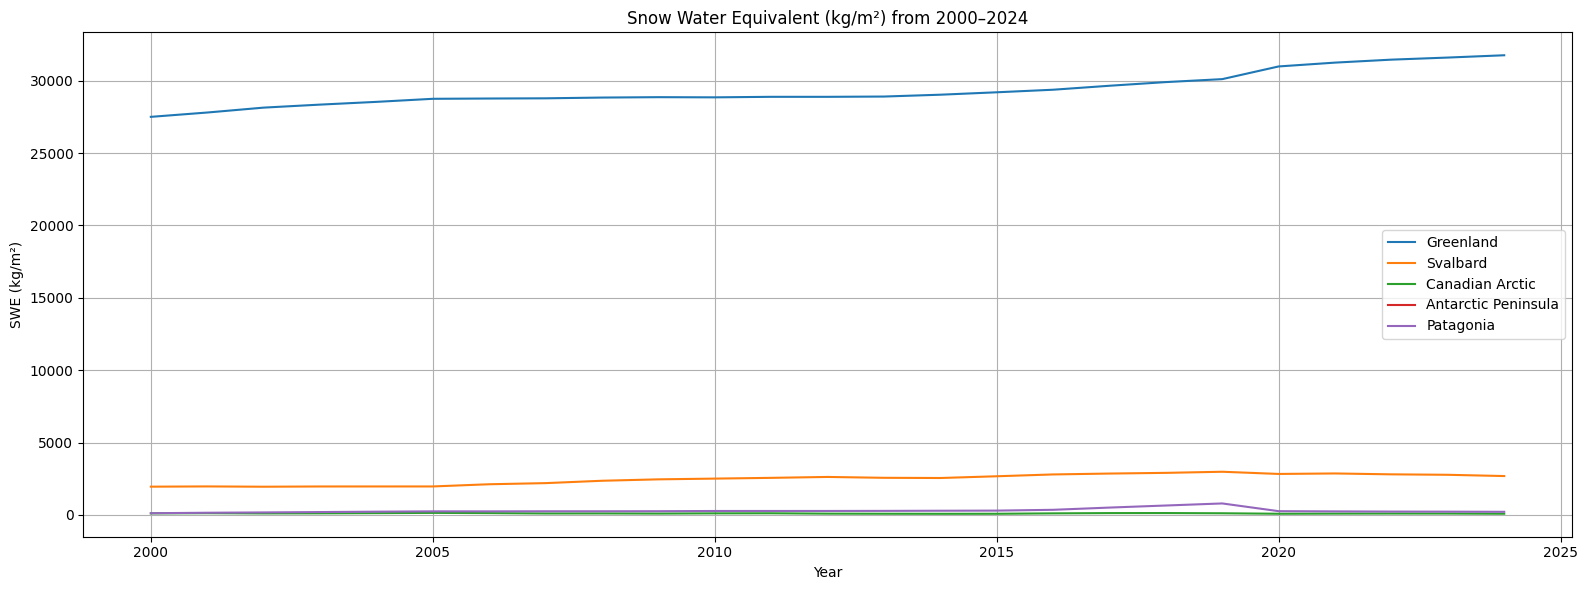

In [21]:
# Snow Depth plot
plt.figure(figsize=(16, 6))
for region in df['Region'].unique():
    region_df = df[df['Region'] == region]
    plt.plot(region_df['Year'], region_df['SnowDepth_m'], label=region)

plt.title("Snow Depth (m) from 2000–2024")
plt.xlabel("Year")
plt.ylabel("Snow Depth (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# SWE plot
plt.figure(figsize=(16, 6))
for region in df['Region'].unique():
    region_df = df[df['Region'] == region]
    plt.plot(region_df['Year'], region_df['SWE_kg_per_m2'], label=region)

plt.title("Snow Water Equivalent (kg/m²) from 2000–2024")
plt.xlabel("Year")
plt.ylabel("SWE (kg/m²)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
image = ee.ImageCollection('NASA/GSFC/MERRA/lnd/2').first()
print(image.bandNames().getInfo())
print(image.getInfo())

['BASEFLOW', 'ECHANGE', 'EVLAND', 'EVPINTR', 'EVPSBLN', 'EVPSOIL', 'EVPTRNS', 'FRSAT', 'FRSNO', 'FRUNST', 'FRWLT', 'GHLAND', 'GRN', 'GWETPROF', 'GWETROOT', 'GWETTOP', 'LAI', 'LHLAND', 'LWLAND', 'PARDFLAND', 'PARDRLAND', 'PRECSNOLAND', 'PRECTOTLAND', 'PRMC', 'QINFIL', 'RUNOFF', 'RZMC', 'SFMC', 'SHLAND', 'SMLAND', 'SNODP', 'SNOMAS', 'SPLAND', 'SPSNOW', 'SPWATR', 'SWLAND', 'TELAND', 'TPSNOW', 'TSAT', 'TSOIL1', 'TSOIL2', 'TSOIL3', 'TSOIL4', 'TSOIL5', 'TSOIL6', 'TSURF', 'TUNST', 'TWLAND', 'TWLT', 'WCHANGE']
{'type': 'Image', 'bands': [{'id': 'BASEFLOW', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [576, 361], 'crs': 'EPSG:4326', 'crs_transform': [0.625, 0, -180.5, 0, 0.5, -90.5]}, {'id': 'ECHANGE', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [576, 361], 'crs': 'EPSG:4326', 'crs_transform': [0.625, 0, -180.5, 0, 0.5, -90.5]}, {'id': 'EVLAND', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [576, 361], 'crs': 'EPSG

In [24]:
regions = {
    'Greenland': ee.Geometry.Polygon([[[-52, 60], [-52, 80], [-30, 80], [-30, 60], [-52, 60]]]),
    'Svalbard': ee.Geometry.Polygon([[[10, 76], [10, 82], [35, 82], [35, 76], [10, 76]]]),
    'Canadian Arctic': ee.Geometry.Polygon([[[-100, 65], [-100, 75], [-70, 75], [-70, 65], [-100, 65]]]),
    'Antarctic Peninsula': ee.Geometry.Polygon([[[-75, -75], [-75, -60], [-50, -60], [-50, -75], [-75, -75]]]),
    'Patagonia': ee.Geometry.Polygon([[[-75, -55], [-75, -45], [-70, -45], [-70, -55], [-75, -55]]]),
}

years = list(range(2000, 2025))
data = []

for year in tqdm(years, desc="Processing MERRA-2 data"):
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'

    merra = ee.ImageCollection('NASA/GSFC/MERRA/lnd/2') \
        .filterDate(start_date, end_date) \
        .select(['SNODP','SNOMAS']) \
        .mean()

    for region_name, geom in regions.items():
        try:
            stats = merra.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geom,
                scale=50000,  # MERRA-2 resolution is coarser (~50km)
                maxPixels=1e13
            ).getInfo()

            data.append({
                'Year': year,
                'Region': region_name,
                'SnowDepth_m': stats.get('SNODP'),
                'SWE_kg_per_m2': stats.get('SNOMAS')
            })

        except Exception as e:
            print(f"Failed for {region_name} in {year}: {e}")
            data.append({
                'Year': year,
                'Region': region_name,
                'SnowDepth_m': None,
                'SWE_kg_per_m2': None
            })
merra_df = pd.DataFrame(data)

Processing MERRA-2 data: 100%|██████████| 25/25 [1:56:06<00:00, 278.67s/it]


In [25]:
print(merra_df)

     Year               Region  SnowDepth_m  SWE_kg_per_m2
0    2000            Greenland     1.019003     361.772346
1    2000             Svalbard     0.579591     166.434269
2    2000      Canadian Arctic     0.386772      96.020716
3    2000  Antarctic Peninsula          NaN            NaN
4    2000            Patagonia     0.105298      15.501313
..    ...                  ...          ...            ...
120  2024            Greenland     0.899314     316.244633
121  2024             Svalbard     0.457838     127.219153
122  2024      Canadian Arctic     0.379359      96.514832
123  2024  Antarctic Peninsula          NaN            NaN
124  2024            Patagonia     0.109539      16.414102

[125 rows x 4 columns]


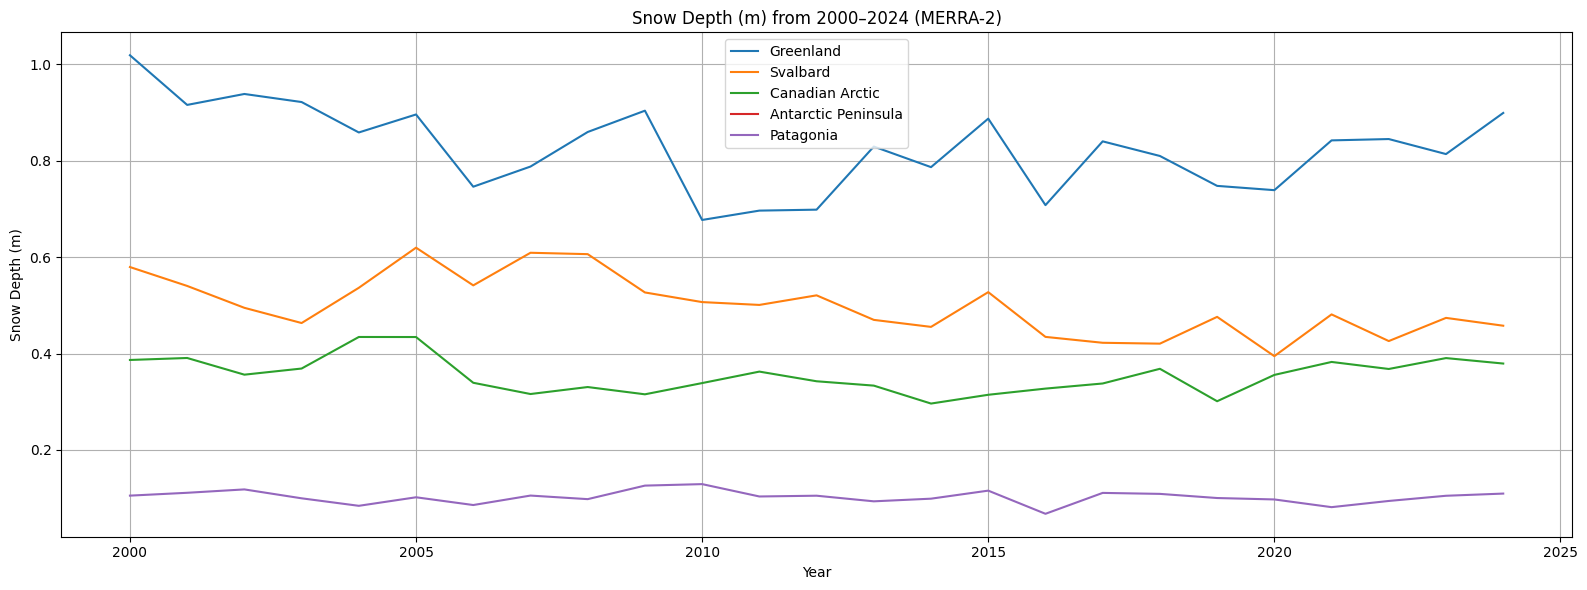

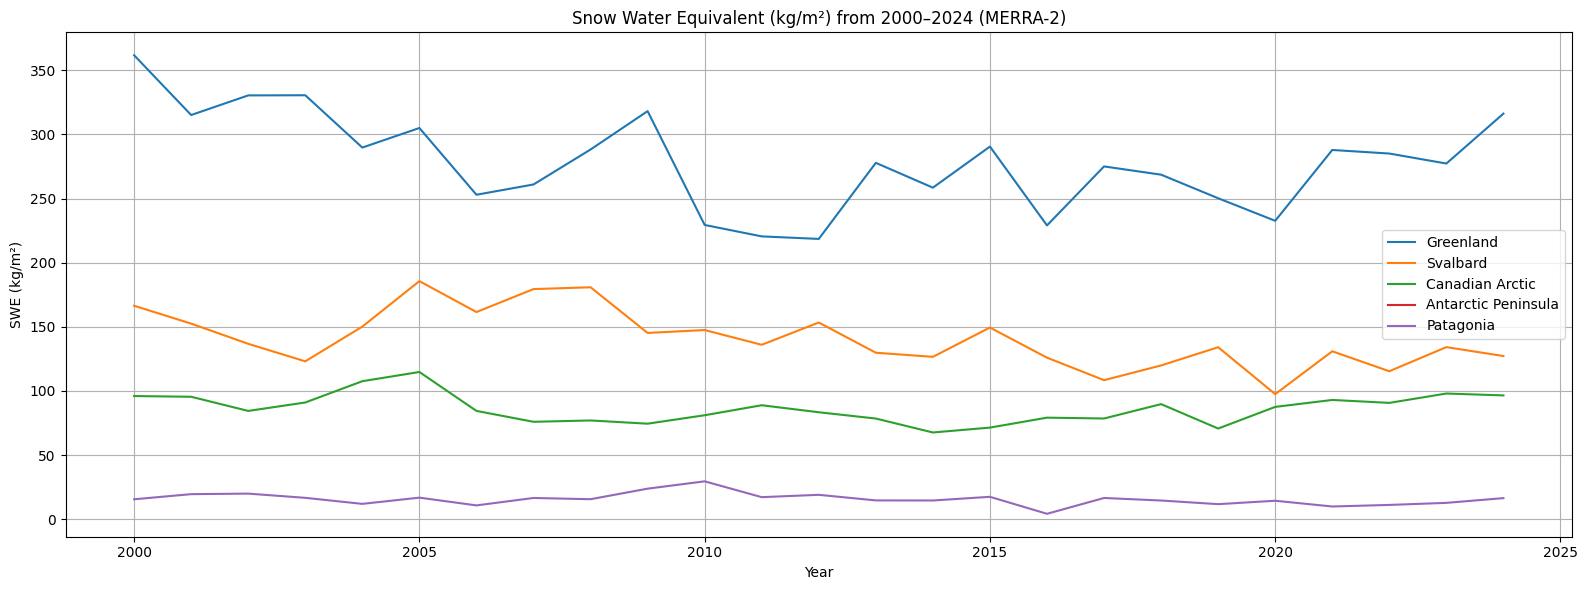

In [81]:
# Plotting Snow Depth
plt.figure(figsize=(16, 6))
for region in merra_df['Region'].unique():
    region_df_sd = merra_df[merra_df['Region'] == region]
    plt.plot(region_df_sd['Year'], region_df_sd['SnowDepth_m'], label=region)

plt.title("Snow Depth (m) from 2000–2024 (MERRA-2)")
plt.xlabel("Year")
plt.ylabel("Snow Depth (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting SWE
plt.figure(figsize=(16, 6))
for region in merra_df['Region'].unique():
    region_df_swe = merra_df[merra_df['Region'] == region]
    plt.plot(region_df_swe['Year'], region_df_swe['SWE_kg_per_m2'], label=region)

plt.title("Snow Water Equivalent (kg/m²) from 2000–2024 (MERRA-2)")
plt.xlabel("Year")
plt.ylabel("SWE (kg/m²)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# MERRA-2	kg/m² or fluxes	~1e-07	Instantaneous, lower resolution, flux-based
# GLDAS/NOAH	kg/m²	~30,000+	Accumulated water equivalent in kg/m²

In [28]:
NewMap = geemap.Map(basemap=geemap.basemaps['OpenStreetMap'])
NewMap.addLayer(merra, {'bands': 'SNODP', 'min': 0, 'max': 2}, 'Snow Depth')
NewMap.addLayer(regions['Antarctic Peninsula'], {}, 'Antarctic Peninsula')
NewMap.centerObject(regions['Antarctic Peninsula'], 4)
NewMap

Map(center=[-67.1893873445001, -62.50000000000001], controls=(WidgetControl(options=['position', 'transparent_…

In [83]:
# This cell is not up-to-date
GLDASMap = geemap.Map(basemap=geemap.basemaps['OpenStreetMap'])
GLDASMap.addLayer(gldas, {'bands': 'SnowDepth_inst', 'min': 0, 'max': 2}, 'Snow Depth')
GLDASMap.addLayer(gldas,{'bands':'SWE_inst', 'min':0, 'max':2}, 'SWE')
GLDASMap.addLayer(regions['Antarctic Peninsula'], {}, 'Antarctic Peninsula')
GLDASMap.centerObject(regions['Antarctic Peninsula'], 4)
display(GLDASMap)

Map(center=[-67.1893873445001, -62.50000000000001], controls=(WidgetControl(options=['position', 'transparent_…

In [30]:
ml_data = []
for region_name, values in results.items():
    for i, year in enumerate(years):
        entry = {
            'Region': region_name,
            'Year': year,
            'SnowMetric': values[i],  #NDSI or VV depending on year
            'Sensor': 'MODIS' if year < 2015 else 'Sentinel-1'
        }
        ml_data.append(entry)

ml_df = pd.DataFrame(ml_data)

In [77]:
print(ml_df)

        Region  Year  SnowMetric      Sensor    SnowRegime
0    Greenland  2000    0.969886       MODIS    Persistent
1    Greenland  2001    0.964246       MODIS    Persistent
2    Greenland  2002    0.967405       MODIS    Persistent
3    Greenland  2003    0.964364       MODIS    Persistent
4    Greenland  2004    0.967647       MODIS    Persistent
..         ...   ...         ...         ...           ...
120  Patagonia  2020  -11.170195  Sentinel-1  Intermittent
121  Patagonia  2021  -11.245183  Sentinel-1  Intermittent
122  Patagonia  2022  -11.494387  Sentinel-1  Intermittent
123  Patagonia  2023  -11.323234  Sentinel-1  Intermittent
124  Patagonia  2024  -11.414192  Sentinel-1  Intermittent

[125 rows x 5 columns]


In [38]:
print(ml_df['SnowMetric'].min())

-16.93079634320252


In [39]:
print(ml_df['SnowMetric'].max())

1.0


In [43]:
def get_snow_metrics_combined(region_geom, year, region_name):
    return {
        'NDSI': ndsi_value,
        'VV': vv_value
    }

In [73]:
def classify_regime(row):
    val = row['SnowMetric']
    year = row['Year']

    if pd.isna(val):
        return 'Unknown'

    # For data up to 2015 (using NDSI)
    if year <= 2015:
        if val >= 0.8:
            return 'Persistent'
        elif val >= 0.4:
            return 'Intermittent'
        else:
            return 'No Snow'

    # For data after 2015 (using Sentinel-1 VV backscatter)
    else:
        if val < -12:
            return 'Persistent'
        elif val < -6:
            return 'Intermittent'
        else:
            return 'No Snow'

ml_df['SnowRegime'] = ml_df.apply(classify_regime, axis=1)

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df_clean = ml_df.dropna(subset=['SnowMetric'])
X = df_clean[['SnowMetric']]
y = df_clean['SnowRegime']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

Intermittent       1.00      1.00      1.00         2
     No Snow       1.00      1.00      1.00        10
  Persistent       1.00      1.00      1.00        18

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [75]:
ml_df['Year'] = ml_df['Year'].astype(int)
ml_df['Region'] = ml_df['Region'].astype(str)
ml_df['SnowRegime'] = ml_df['SnowRegime'].astype('category')

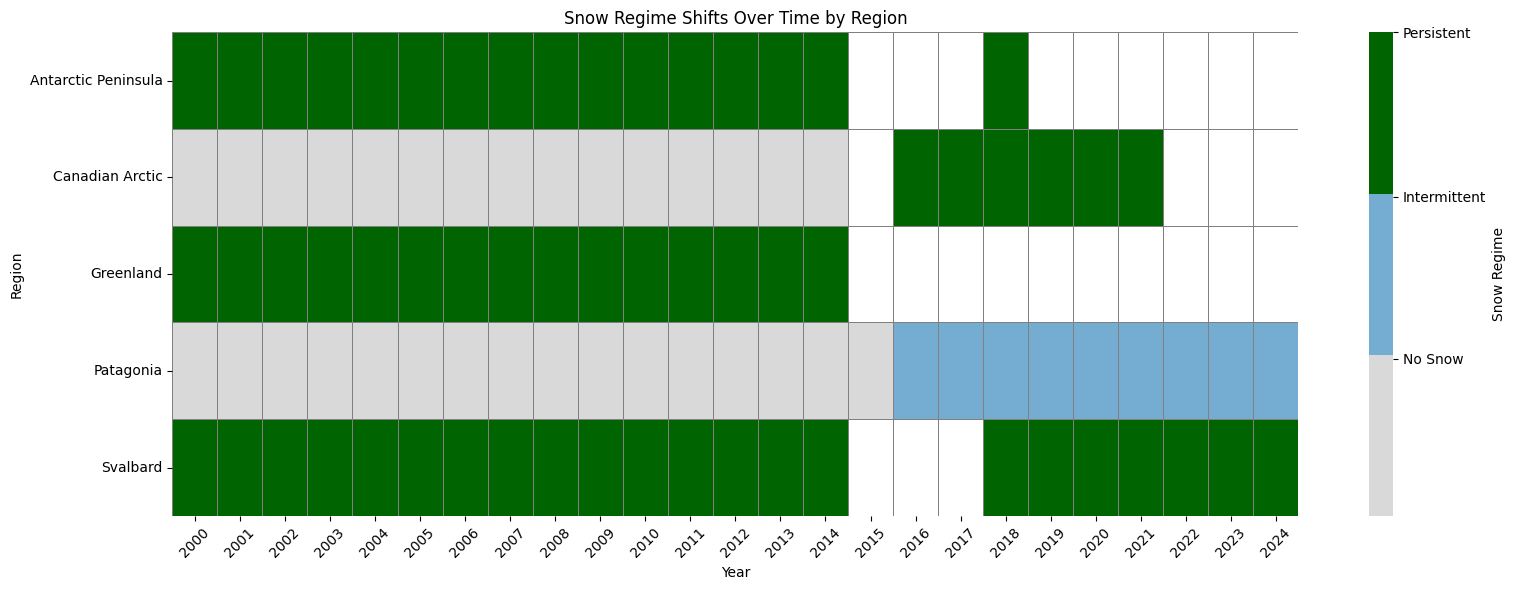

In [85]:
df_filtered = ml_df[ml_df['SnowRegime'].isin(['No Snow', 'Intermittent', 'Persistent'])].copy()

pivot_df = df_filtered.pivot(index='Region', columns='Year', values='SnowRegime')

regime_palette = {
    'No Snow': 0,
    'Intermittent': 1,
    'Persistent': 2
}
numeric_df = pivot_df.replace(regime_palette)
numeric_df = numeric_df.apply(pd.to_numeric, errors='coerce')  # Force all values to numeric

colors = ['#d9d9d9', '#74add1', '#006400']

plt.figure(figsize=(16, 6))
sns.heatmap(numeric_df, cmap=colors, linewidths=0.5, linecolor='gray',cbar_kws={'ticks': [0.5, 1.5, 2.5], 'label': 'Snow Regime'})
plt.title('Snow Regime Shifts Over Time by Region')
plt.xlabel('Year')
plt.ylabel('Region')
plt.xticks(rotation=45)
colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([0.65, 1.32, 2])
colorbar.set_ticklabels(['No Snow', 'Intermittent', 'Persistent'])

plt.tight_layout()
plt.show()